In [54]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [55]:
import pandas as pd
import numpy as np
import sklearn
from textblob import Word
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
import nltk
import nltk
import re
import itertools
import time
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
#loading the dataset
mooc_df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/MoocSentimentAnalysis/stanfordMOOCForumPostsSet.xlsx") 

In [57]:
# checking the no of columns
mooc_df.columns

Index(['Text', 'Opinion(1/0)', 'Question(1/0)', 'Answer(1/0)',
       'Sentiment(1-7)', 'Confusion(1-7)', 'Urgency(1-7)', 'CourseType',
       'forum_post_id', 'course_display_name', 'forum_uid', 'created_at',
       'post_type', 'anonymous', 'anonymous_to_peers', 'up_count',
       'comment_thread_id', 'reads'],
      dtype='object')

Refmoving unwanted columns and kept only Sentiment and Text columns, as we need to make prediction on Sentiment column based on Text.

In [58]:
mooc_df = mooc_df.drop(['Opinion(1/0)','Question(1/0)', 'Answer(1/0)','Confusion(1-7)', 'Urgency(1-7)', 'CourseType',
       'forum_post_id', 'course_display_name', 'forum_uid', 'created_at',
       'post_type', 'anonymous', 'anonymous_to_peers', 'up_count',
       'comment_thread_id', 'reads'], axis =1)

In [40]:
print(mooc_df.shape)
print(mooc_df.columns)

(29604, 2)
Index(['Text', 'Sentiment(1-7)'], dtype='object')


Some of the rows contains integers in the text columns as part of preprocessing wil remove these rows.

In [59]:
not_string =[]
for i in range(0, len(mooc_df)):
    #print(type(forumPosts['Text'][i]))
    if type(mooc_df['Text'][i])!=str:
        not_string.append(i)

Removing the rows having integers in text columns

In [60]:
mooc_df = mooc_df.drop(not_string)

Checking the no of entries for each category in the dateset

In [61]:
abc = mooc_df.groupby("Sentiment(1-7)")["Text"].count()
abc

Sentiment(1-7)
1.0       14
1.5       46
2.0       97
2.5      353
3.0     1165
3.5     2712
4.0    16297
4.5     4261
5.0     2391
5.5     1184
6.0      686
6.5      310
7.0       82
Name: Text, dtype: int64

As given in the readme file of the mooc dataset that:

sentiment is expressed in post as folllowing:
1=negative;
7=positive;
4=neutral;

But the dataset has following values (not only 1, 4 and 7)


*   1
*   1.5
*   2
*   2.5
*   3
*   3.5
*   4
*   4.5
*   5
*   5.5
*   6
*   6.5
*   7

 So i am the sentiments as follows

*   Negative: values between (1,3.5)
*   Neutarl: if value is 4
*   Positive: values between (4.5,7)

In [62]:
def int_to_string(sentiment):
    if sentiment in [1,1.5,2,2.5,3,3.5]:
        return 0
    elif sentiment == 4:
        return 4
    else:
        return 7


In [63]:
mooc_df["Sentiment(1-7)"] = mooc_df["Sentiment(1-7)"].apply(int_to_string)

In [64]:
sentiment_distribution = mooc_df.groupby("Sentiment(1-7)")["Text"].count()
sentiment_distribution = sentiment_distribution.reset_index(name="no of entries")
sentiment_distribution

,Sentiment(1-7),no of entries
0,0,4387
1,4,16297
2,7,8914


We will check the count of positive negative and neutral entries, to check if data is biased or not. 

Here from the plot we can see that the no of neutarl entries are much higher compared with positive and negative entries. This issue may not give higher accuracy for the model, thugh we will proceed for the model building for now.

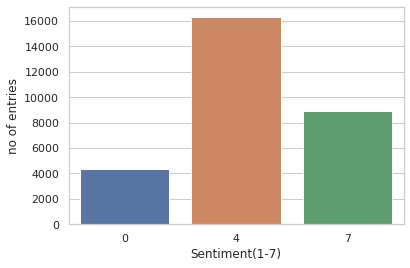

In [65]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Sentiment(1-7)", y="no of entries", data=sentiment_distribution)

Function for datapreprocessing

In [66]:
def preprocess_data(mooc_df):
    '''
    Cleaning the data by performing following tasks:
    1. Removing NaN rows
    2. Removing special characters
    3. Lowercase all the words
    4. Removing null, start and end
    5. Applying lemmatize to each word
    6. Removing all stop words
    '''
    mooc_df['Text'].dropna(inplace=True)
    mooc_df['Text'] = mooc_df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    mooc_df['Text'] = mooc_df['Text'].str.replace('[^\w\s]','')
    stop = stopwords.words('english')
    mooc_df['Text'] = mooc_df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    mooc_df['Text'] = mooc_df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in ["null", "start", "end"]))
    mooc_df['Text'] = mooc_df['Text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    return mooc_df

In [67]:
mooc_df['Text'] = preprocess_data(mooc_df)

Now the final dataset has only two columns Text (removed all the rows having integers) and the target column is Sentiment(1-7)

In [68]:
mooc_df.head()

,Text,Sentiment(1-7)
0,interesting often say thing others without rea...,7
1,algebra math game saying create game incorpora...,4
2,like idea kid principal say smart doesnt mean ...,7
3,response seems student really liked power felt...,7
4,boy loved math freedom anything great way see ...,7


In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(mooc_df['Text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [72]:
max_fatures = 3000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(mooc_df['Text'].values)
X1 = tokenizer.texts_to_sequences(mooc_df['Text'].values)
X1 = pad_sequences(X1)
Y1 = pd.get_dummies(mooc_df['Sentiment(1-7)']).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


(22198, 233) (22198, 3)
(7400, 233) (7400, 3)


In [73]:
embed_dim = 150
lstm_out = 200
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X1.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 233, 150)          450000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               280800    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 731,403
Trainable params: 731,403
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
batch_size = 32
model.fit(X1_train, Y1_train, epochs = 1, batch_size=batch_size, verbose = 2)

694/694 - 431s - loss: 0.7425 - accuracy: 0.6867


In [75]:
history = model.fit(X1_train, Y1_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X1_test, Y1_test),
                    batch_size=64)

Epoch 1/5
347/347 [==============================] - 374s 1s/step - loss: 0.5975 - accuracy: 0.7544 - val_loss: 0.6797 - val_accuracy: 0.7115
Epoch 2/5
347/347 [==============================] - 380s 1s/step - loss: 0.5374 - accuracy: 0.7784 - val_loss: 0.6896 - val_accuracy: 0.7146
Epoch 3/5
347/347 [==============================] - 384s 1s/step - loss: 0.4903 - accuracy: 0.8012 - val_loss: 0.7278 - val_accuracy: 0.7014
Epoch 4/5
347/347 [==============================] - 388s 1s/step - loss: 0.4444 - accuracy: 0.8212 - val_loss: 0.7714 - val_accuracy: 0.6991
Epoch 5/5
347/347 [==============================] - 382s 1s/step - loss: 0.4012 - accuracy: 0.8430 - val_loss: 0.8390 - val_accuracy: 0.6999
